In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Loading EMNIST Dataset

In [2]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Preparing Training and Test Set

In [3]:
#train set
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float64)
Y_etrain=train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape

# test set
X_etest=torch.flatten(test_edata.data,1,2).to(torch.float64)
Y_etest=test_edata.targets.reshape(X_etest.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape,X_etest.shape,Y_etest.shape

(torch.Size([112800, 784]),
 torch.Size([112800, 1]),
 torch.Size([18800, 784]),
 torch.Size([18800, 1]))

In [4]:
# scaling train dataset
for i in range(X_etrain.shape[0]):
    X_etrain[i]=(X_etrain[i]-X_etrain[i].min())/(X_etrain[i].max()-X_etrain[i].min())


# scaling test dataset
for i in range(X_etest.shape[0]):
    X_etest[i]=(X_etest[i]-X_etest[i].min())/(X_etest[i].max()-X_etest[i].min())

In [5]:
## One hot encoding For the labels

Y_enc_etrain=torch.zeros((Y_etrain.shape[0],len(train_edata.classes))).to(torch.int8)

for i in range(Y_etrain.shape[0]):
    Y_enc_etrain[i][Y_etrain[i].item()]=1


Y_enc_etest=torch.zeros((Y_etest.shape[0],len(test_edata.classes))).to(torch.int8)

for i in range(Y_etest.shape[0]):
    Y_enc_etest[i][Y_etest[i].item()]=1


Y_enc_etrain.shape,Y_enc_etest.shape

(torch.Size([112800, 47]), torch.Size([18800, 47]))

## Weight and Bias Initialization

In [6]:
# torch.manual_seed(42)

num_input=X_etrain.shape[1]
num_hidden=128


# kaiming weight initialization
W1=torch.randn((num_input,num_hidden),dtype=torch.float64,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))
b1=torch.randn((1,num_hidden),dtype=torch.float64,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))

W2=torch.randn((num_hidden,Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))
b2=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float64,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))


print(f"shape- W1: {W1.shape}\
       \nshape- b1: {b1.shape}\
      \nshape- W2: {W2.shape}\
      \nshape- b2: {b2.shape}")

shape- W1: torch.Size([784, 128])       
shape- b1: torch.Size([1, 128])      
shape- W2: torch.Size([128, 47])      
shape- b2: torch.Size([1, 47])


## Utility Functions

In [7]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()

In [8]:
#check manually calculated gradients with that of pytorch autograd
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

## Gamma and Beta Initialization

In [9]:
batch_size=160

# a single batch
X_btrain=X_etrain[:batch_size,:]
Y_btrain=Y_enc_etrain[:batch_size,:]

gamma=torch.randn((1,num_hidden),requires_grad=True,dtype=torch.float64)
beta=torch.randn((1,num_hidden),requires_grad=True,dtype=torch.float64)

X_btrain.shape,Y_btrain.shape



(torch.Size([160, 784]), torch.Size([160, 47]))

## Validating Manual Backpropagation by Comparing with `torch.autograd`

In [10]:
# first layer
Z1=X_btrain@W1 + b1
A1=torch.tanh(Z1)

A1_mean=A1.sum(dim=0,keepdim=True)/A1.shape[0]
A1_std=(torch.sqrt(torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)/A1.shape[0])) 
# A1_std=A1.std(dim=0,keepdim=True)
A1_norm=(A1-A1_mean)/(A1_std)   

# batch normalization
A2=A1_norm*gamma+beta

# output layer
Z2=A2@W2 + b2
Y_ehat=softmax(Z2)

# Loss=categorical_cross_entropy(Y_btrain,Y_ehat)
Loss=torch.sum((-Y_btrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

# backpropgation

dL_dZ2=(Y_ehat-Y_btrain)/X_btrain.shape[0]
dZ2_dW2=A2

dL_dW2=dZ2_dW2.T@dL_dZ2
dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


dZ2_dA2=W2
dL_dA2= dL_dZ2 @ dZ2_dA2.T

dA2_dgamma=A1_norm
dL_dgamma=torch.sum(dL_dA2*dA2_dgamma,dim=0,keepdim=True)
dL_dbeta=torch.sum(dL_dA2,dim=0,keepdim=True)

dA2_dA1_norm=gamma  
dL_dA1_norm=dL_dA2*dA2_dA1_norm    

dA1_norm_dA1_std= -(A1-A1_mean)*(A1_std**-2)
dA1_norm_dA1_mean=-(A1_std**-1)
dA1_norm_dA1=A1_std**-1

dA1_std_dA1_mean=((1/(A1.shape[0]**(1/2)))*(((torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)))**(-0.5))*(A1-A1_mean)*-1)
dA1_std_dA1=(1/(A1.shape[0]**(1/2)))*(((torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)))**(-0.5))*(A1-A1_mean)


dL_dA1_std=torch.sum(dL_dA1_norm*dA1_norm_dA1_std,dim=0,keepdim=True)   

dL_dA1_mean=torch.sum(dA1_norm_dA1_mean*dL_dA1_norm,dim=0,keepdim=True) 
dL_dA1_mean+=torch.sum(dA1_std_dA1_mean*dL_dA1_std,dim=0,keepdim=True)


dA1_mean_dA1=(torch.ones_like(A1)/A1.shape[0])

dL_dA1=dA1_norm_dA1*dL_dA1_norm
dL_dA1+=dA1_std_dA1*dL_dA1_std
dL_dA1+=(1/A1.shape[0])*dL_dA1_mean


# dA1_dZ1=torch.where((Z1<0),0, 1)
dA1_dZ1=(1-(torch.tanh(Z1))**2)

dL_dZ1=(dA1_dZ1 * dL_dA1)

dZ1_dW1=X_btrain

dL_dW1=dZ1_dW1.T @ dL_dZ1
dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

for each in [Z2,A2,A1_norm,gamma,beta,A1_std,A1_mean,W1,W2,b1,b2,A1,Z1]:
    each.retain_grad()


In [11]:
Loss.backward()

In [12]:
cmp("dZ2", dL_dZ2, Z2)
cmp("dW2", dL_dW2, W2)
cmp("db2", dL_db2, b2)
cmp("dA2", dL_dA2, A2)
cmp("dgamma", dL_dgamma, gamma)
cmp("dbeta", dL_dbeta, beta)
cmp("dA1_norm", dL_dA1_norm, A1_norm)
cmp("dA1_std", dL_dA1_std, A1_std)
cmp("dA1_mean", dL_dA1_mean, A1_mean)
cmp("dA1", dL_dA1, A1)
cmp("dZ1", dL_dZ1, Z1)
cmp("dW1", dL_dW1, W1)
cmp("db1", dL_db1, b1)

## Training the Model with Batch Normalization

In [13]:
loss_list_train=[]
loss_list_test=[]

In [14]:
A1_test_mean=0
A1_test_std=0
alpha=0.01

for i in range(100):
    idx=0
    for batch in range(torch.tensor(int(X_etrain.shape[0]/batch_size))):

        X_btrain=X_etrain[idx:batch_size+idx,:]
        Y_btrain=Y_enc_etrain[idx:batch_size+idx,:]

        idx=idx+batch_size

        # first layer
        Z1=X_btrain@W1 + b1
        A1=torch.tanh(Z1)

        A1_mean=A1.sum(dim=0,keepdim=True)/A1.shape[0]
        A1_std=(torch.sqrt(torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)/A1.shape[0])) #+1e-10 # adding small term with std to eliminate dividing by 0 at A1_norm
        # A1_std=A1.std(dim=0,keepdim=True)
        A1_norm=(A1-A1_mean)/(A1_std)   

        # batch normalization
        A2=A1_norm*gamma+beta

        # output layer
        Z2=A2@W2 + b2
        Y_ehat=softmax(Z2)

        # Loss=categorical_cross_entropy(Y_btrain,Y_ehat)
        Loss=torch.sum((-Y_btrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

        # backpropgation

        dL_dZ2=(Y_ehat-Y_btrain)/X_btrain.shape[0]
        dZ2_dW2=A2

        dL_dW2=dZ2_dW2.T@dL_dZ2
        dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


        dZ2_dA2=W2
        dL_dA2= dL_dZ2 @ dZ2_dA2.T

        dA2_dgamma=A1_norm
        dL_dgamma=torch.sum(dL_dA2*dA2_dgamma,dim=0,keepdim=True)
        dL_dbeta=torch.sum(dL_dA2,dim=0,keepdim=True)

        dA2_dA1_norm=gamma  
        dL_dA1_norm=dL_dA2*dA2_dA1_norm    

        dA1_norm_dA1_std= -(A1-A1_mean)*(A1_std**-2)
        dA1_norm_dA1_mean=-(A1_std**-1)
        dA1_norm_dA1=A1_std**-1

        dA1_std_dA1_mean=((1/(A1.shape[0]**(1/2)))*(((torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)))**(-0.5))*(A1-A1_mean)*-1)
        dA1_std_dA1=(1/(A1.shape[0]**(1/2)))*(((torch.sum(((A1-A1_mean)**2),dim=0,keepdim=True)))**(-0.5))*(A1-A1_mean)


        dL_dA1_std=torch.sum(dL_dA1_norm*dA1_norm_dA1_std,dim=0,keepdim=True)   

        dL_dA1_mean=torch.sum(dA1_norm_dA1_mean*dL_dA1_norm,dim=0,keepdim=True) 
        dL_dA1_mean+=torch.sum(dA1_std_dA1_mean*dL_dA1_std,dim=0,keepdim=True)


        dA1_mean_dA1=(torch.ones_like(A1)/A1.shape[0])

        dL_dA1=dA1_norm_dA1*dL_dA1_norm
        dL_dA1+=dA1_std_dA1*dL_dA1_std
        dL_dA1+=(1/A1.shape[0])*dL_dA1_mean


        # dA1_dZ1=torch.where((Z1<0),0, 1)
        dA1_dZ1=(1-(torch.tanh(Z1))**2)

        dL_dZ1=(dA1_dZ1 * dL_dA1)

        dZ1_dW1=X_btrain

        dL_dW1=dZ1_dW1.T @ dL_dZ1
        dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

        A1_test_mean=alpha*A1_test_mean+(1-alpha)*A1_mean
        A1_test_std=alpha*A1_test_std+(1-alpha)*A1_std

        with torch.no_grad():
        # weights and biases optimization
            W2-=0.01*dL_dW2
            b2-=0.01*dL_db2
            W1-=0.01*dL_dW1
            b1-=0.01*dL_db1

    # Test first layer
    Z1_test=X_etest@W1 + b1
    A1_test=torch.tanh(Z1_test)
    A1_norm_test=(A1_test-A1_test_mean)/(A1_test_std)   

    # batch normalization
    A2_test=A1_norm_test*gamma+beta

    # output layer
    Z2_test=A2_test@W2 + b2
    Y_ehat_test=softmax(Z2_test)

    Loss_test=torch.sum((-Y_enc_etest*torch.log(Y_ehat_test)),dim=1,keepdim=True).mean()

    loss_list_train.append(Loss.item())
    loss_list_test.append(Loss_test.item())


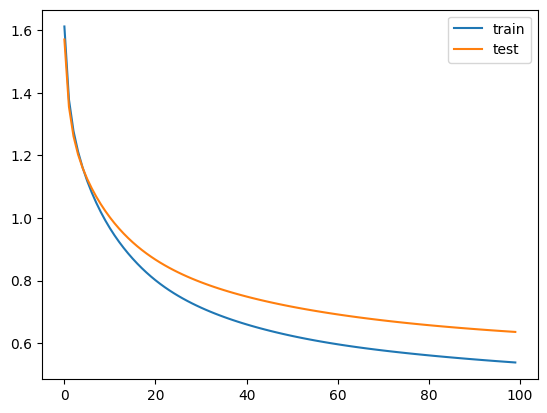

In [15]:
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.show()

## Train and Test Set Prediction

In [21]:
# last batch train accuracy
train_batch_accuracy=torch.sum(torch.where(Y_ehat.argmax(dim=1)==Y_btrain.argmax(dim=1),1,0))/Y_btrain.shape[0]


# test accuracy
predictions_test = Y_ehat_test.argmax(dim=1)
test_accuracy=torch.sum(torch.where(predictions_test==Y_enc_etest.argmax(dim=1),1,0))/predictions_test.shape[0]


print(f"Last Batch - Train Accuracy: {train_batch_accuracy*100}%")
print(f"Test Accuracy: {test_accuracy*100}%")

Last Batch - Train Accuracy: 83.125%
Test Accuracy: 80.64361572265625%
